### Maximum Margin IRL from Trajectories

#### Reward Function Representation
The reward function is modeled as a linear combination of Gaussian basis functions:
$$
R(s) = \sum_{i=1}^{d} \alpha_i \phi_i(s)
$$
where $\phi_i(s)$ are Gaussian basis functions, and $\alpha_i$ are weights.

---

#### Basis Functions
Each Gaussian basis function is defined as:
$$
\phi_i(s) = \exp\left(-\frac{(s - \mu_i)^2}{2\sigma^2}\right)
$$
where $\mu_i$ is the mean and $\sigma$ the standard deviation.

- $\{\phi_i(s)\}_{i=1}^{d}$ span the state space.
- $\sigma$ controls overlap and smoothness.

---

#### Value Function Estimation
The value function under policy $\pi$ is:
$$
\hat{V}^{\pi}(S_0) = \mathbb{E}\left[\sum_{t=0}^{T} \beta^t R(S_t)\right]
$$
Substituting $R(s)$:
$$
\hat{V}^{\pi}(S_0) = \sum_{i=1}^{d} \alpha_i \mathbb{E}\left[\sum_{t=0}^{T} \beta^t \phi_i(S_t)\right] = \sum_{i=1}^{d} \alpha_i \hat{V}_i^{\pi}(S_0)
$$
where $\beta$ is the discount factor.

---

#### Data Requirements
- Trajectories $\{S_0, S_1, \dots, S_T\}$ under optimal policy $\pi^*$.
- Properties:
  - Diverse initial states $S_0$.
  - Sufficient length $T$.
  - Enough trajectories for robust estimation.

---

#### Linear Programming for Reward Estimation
To estimate $\alpha_i$, solve:
$$
\text{maximize} \quad \sum_{i=1}^{d} (\hat{V}^{\pi^*}_i(S_0) - \hat{V}^{\pi_{\text{rand}}}_i(S_0)) \alpha_i
$$
Subject to:
$$
|\alpha_i| \leq 1, \quad \forall i
$$

---

#### Iterative Refinement
1. Initialization: Use $\pi^*$ trajectories to estimate $\hat{V}^{\pi^*}$.
2. Policy Simulation: Generate trajectories using the current reward estimate.
3. Value Update: Recalculate $\hat{V}_i^{\pi}$ for updated policies.
4. Optimize: Solve LP to update $\alpha_i$.
5. Convergence Check: Stop if $\|\alpha^{(k+1)} - \alpha^{(k)}\| < \epsilon$.

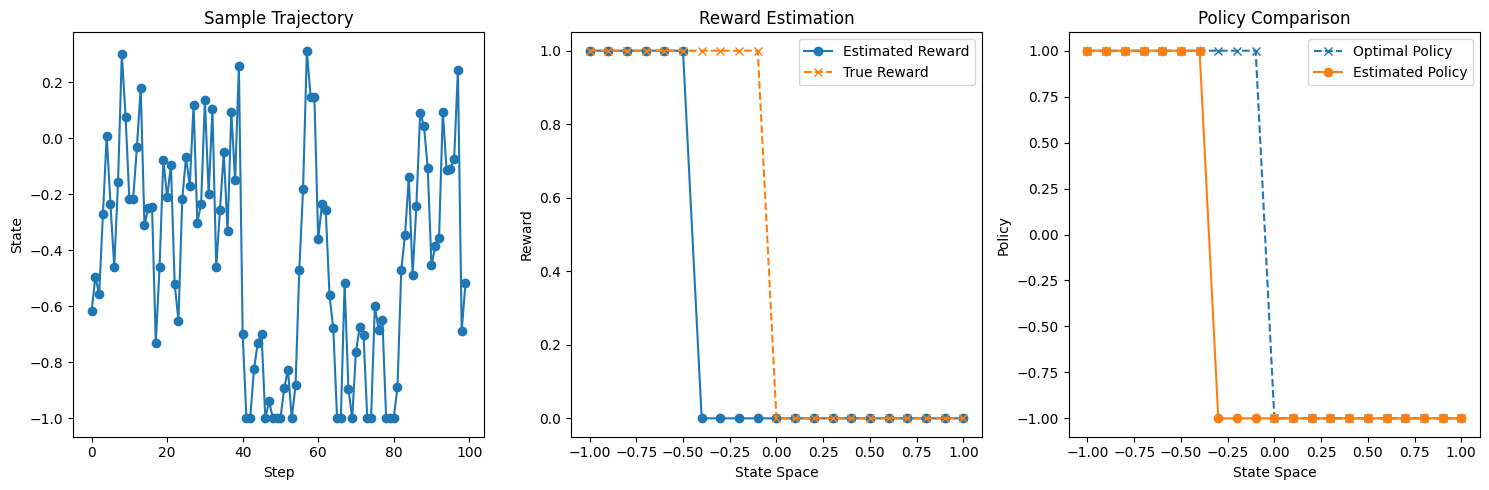

In [ ]:
import numpy as np
from numpy.random import uniform
from functools import reduce
from scipy.stats import norm
from scipy.optimize import linprog
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

############################
# Hyperparameters
############################

# Seed for reproducibility
SEED = 1234
np.random.seed(SEED)

# Simulation Parameters
N_TRAJECTORIES = 20         # Number of trajectories to simulate per policy
TRAJECTORY_LENGTH = 100     # Number of steps per trajectory

# IRL Algorithm Parameters
DISCOUNT_FACTOR = 0.9       # Discount factor for future rewards
N_BASIS_FUNCTIONS = 21      # Number of Gaussian basis functions
MAX_ITERATIONS = 20         # Maximum number of IRL iterations
CONVERGENCE_THRESHOLD = 0.1 # Threshold for alpha convergence

############################
# Helper Functions
############################

def pi_star(s):
    """Optimal policy: Stay (1) if s < 0, Switch (-1) if s >= 0."""
    return 1 if s < 0 else -1

def noise():
    """Random noise uniform in [-0.5, 0.5]."""
    return uniform(-0.5, 0.5)

def truncate_state(s):
    """Truncate state s to be within [-1, 1]."""
    return max(-1, min(1, s))

def step(s, policy):
    """Compute the next state using policy(s), adding noise, and truncating."""
    return truncate_state(policy(s) * s + noise())

def monte_carlo_sim(policy, n_trajectories=N_TRAJECTORIES, trajectory_length=TRAJECTORY_LENGTH):
    """Simulate multiple trajectories under a given policy."""
    trajectories = []
    for _ in range(n_trajectories):
        s0 = uniform(-1, 1)
        traj = [s0]
        for __ in range(trajectory_length - 1):
            s_next = step(traj[-1], policy)
            traj.append(s_next)
        trajectories.append(traj)
    return trajectories

def calc_value_function_estimate(trajectories, discount=DISCOUNT_FACTOR, n_basis=N_BASIS_FUNCTIONS):
    """
    Calculate the value function estimates for a given set of trajectories.
    - Gaussian basis functions span the state space.
    - Discounted sums of rewards are averaged over trajectories.
    """
    means = np.linspace(-1, 1, n_basis)
    sd = 2 / 22
    max_length = max(len(traj) for traj in trajectories)
    discounts = np.array([discount**t for t in range(max_length)])
    
    values = np.zeros(n_basis)
    for i, m in enumerate(means):
        traj_returns = []
        for traj in trajectories:
            phi_values = norm.pdf(traj, loc=m, scale=sd)
            effective_discounts = discounts[: len(traj)]
            traj_return = np.sum(phi_values * effective_discounts)
            traj_returns.append(traj_return)
        values[i] = np.mean(traj_returns) if traj_returns else 0.0
    return values

def reward_function(s, alpha, n_basis=N_BASIS_FUNCTIONS):
    """Compute R(s) = sum(alpha_i * phi_i(s)), where phi_i are Gaussian basis functions."""
    means = np.linspace(-1, 1, n_basis)
    sd = 2 / 22
    phi_values = norm.pdf(s, loc=means, scale=sd)
    return np.sum(alpha * phi_values)

def construct_random_policy():
    """Generate a random policy based on a random inflection point and shape."""
    shape = np.random.choice([-1, 1])
    inflection = np.random.choice(np.linspace(-1, 1, 21))
    return lambda s: -shape if s < inflection else shape

def solve_lp_for_alphas(value_pi_star, list_of_other_values):
    """Solve the LP to estimate alphas maximizing differences in value functions."""
    V_pi_star = list_of_other_values[-1]
    total_diff = np.zeros_like(V_pi_star)
    for j in range(len(list_of_other_values) - 1):
        total_diff += (V_pi_star - list_of_other_values[j])
    c = -total_diff  # Maximize by minimizing negative
    A_ub = np.eye(len(c))
    b_ub = np.ones(len(c))
    res = linprog(c, A_ub=A_ub, b_ub=b_ub, bounds=(0, 1), method='highs')
    if res.success:
        return res.x
    else:
        raise ValueError("LP did not find a feasible solution.")

def lp_irl_sample_trajectories(data, max_iter=MAX_ITERATIONS, discount=DISCOUNT_FACTOR, n_basis=N_BASIS_FUNCTIONS):
    """Run the iterative IRL process to estimate alphas and value functions."""
    value_pi_star = calc_value_function_estimate(data, discount=discount, n_basis=n_basis)
    value_functions = [value_pi_star]
    alpha = np.zeros(n_basis)
    pi_current = construct_random_policy()
    
    for i in range(max_iter):
        traj = monte_carlo_sim(pi_current)
        value_pi_current = calc_value_function_estimate(traj, discount=discount, n_basis=n_basis)
        value_functions = [value_pi_current] + value_functions
        alpha_next = solve_lp_for_alphas(value_functions[-1], value_functions)
        if i >= 4 and np.max(np.abs(alpha_next - alpha)) < CONVERGENCE_THRESHOLD:
            return alpha_next, value_functions
        alpha = alpha_next
        pi_current = lambda s, alpha=alpha: 1 if reward_function(s, alpha) > 0.5 else -1
    return alpha, value_functions

############################
# Main Execution
############################

if __name__ == "__main__":
    data = monte_carlo_sim(pi_star, n_trajectories=N_TRAJECTORIES, trajectory_length=TRAJECTORY_LENGTH)
    alpha_est, _ = lp_irl_sample_trajectories(data)
    true_reward = np.array([1]*10 + [0]*11)
    x_vals = np.linspace(-1, 1, N_BASIS_FUNCTIONS)
    
    plt.figure(figsize=(15, 5))
    
    # (1) Plot a sample trajectory
    plt.subplot(1, 3, 1)
    plt.plot(data[0], marker='o')
    plt.title("Sample Trajectory")
    plt.xlabel("Step")
    plt.ylabel("State")
    
    # (2) Plot reward estimates vs true reward
    plt.subplot(1, 3, 2)
    plt.plot(x_vals, alpha_est, label="Estimated Reward", marker='o')
    plt.plot(x_vals, true_reward, label="True Reward", linestyle='--', marker='x')
    plt.title("Reward Estimation")
    plt.xlabel("State Space")
    plt.ylabel("Reward")
    plt.legend()
    
    # (3) Plot policy comparison
    plt.subplot(1, 3, 3)
    optimal_policy = [pi_star(x) for x in x_vals]
    estimated_policy = [1 if reward_function(x, alpha_est) > 0.5 else -1 for x in x_vals]
    plt.plot(x_vals, optimal_policy, label="Optimal Policy", linestyle='--', marker='x')
    plt.plot(x_vals, estimated_policy, label="Estimated Policy", marker='o')
    plt.title("Policy Comparison")
    plt.xlabel("State Space")
    plt.ylabel("Policy")
    plt.legend()
    
    plt.tight_layout()
    plt.show()